# Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import math
import random
import timeit

from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, mean_absolute_error

---

In [2]:
marburg = pd.read_pickle("../0_data/marburg_clean.pkl")
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
marburg_weather = pd.read_pickle("../0_data/weather/marburg_weather.pkl")
duisburg_weather = pd.read_pickle("../0_data/weather/duisburg_weather.pkl")

# Radial Basis Function

We use the Kernel Ridge Regression Model from scikit-learn.

In [3]:
def rbf_ridge_model(sigma, alpha):
    rbf_ridge = KernelRidge(alpha=alpha, kernel=RBF(sigma))
    rbf_ridge.fit(X_train, y_train)
    
    return rbf_ridge

The function *calc_errors* calculates the Mean Squared Error for the model above using different values for bandwidth $\sigma$ and the regularization parameter $\alpha$.  
These values are determined by *sigma_range* and *alpha_range*.

In [4]:
def calc_errors(sigma_range, alpha_range):
    sigma_length = len(sigma_range)
    alpha_length = len(alpha_range)

    errors_arr = np.empty((sigma_length, alpha_length))
    for i, sigma in enumerate(sigma_range):
        for j, alpha in enumerate(alpha_range):
            errors_arr[i][j] = mean_squared_error(rbf_ridge_model(sigma, alpha).predict(X_val), y_val)
    
    errors = pd.DataFrame(errors_arr, columns = alpha_range, index = sigma_range)

    return errors.sort_index(ascending=False)

The function *split_data* splits the given dataset in train, hold and test datasets of respective sizes of 50%, 20% and 30%.

In [5]:
def split_data(X, y):
    # Do a 50-50 split first
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=34)

    # Now split X_test to achive 50-20-30 split
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=(0.2/0.5),random_state=34)

    for name, data in {'train': X_train, 'validation': X_val, 'test': X_test}.items():
        print("""{}
        {} entries
        ~{:.2f}% of total data

        """.format(name, len(data), len(data)/len(X)))
        
    return X_train, X_val, X_test, y_train, y_val, y_test 

## Marburg

In [6]:
# peak demand
ma = pd.DataFrame(marburg.resample('H').count()["day"])
ma.rename(columns={'day': 'demand'}, inplace=True)

ma['dayofyear'] = ma.index.map(lambda datetime : datetime.dayofyear)
ma['week'] = ma.index.map(lambda datetime : datetime.week)
ma['weekday'] = ma.index.map(lambda datetime : datetime.weekday)
ma['is_weekday'] = ma['weekday'].map(lambda day : day < 5)
ma['hour'] = ma.index.map(lambda datetime : datetime.hour)

ma = ma.merge(marburg_weather, left_index=True, right_index=True)

In [7]:
X = ma[['temperature', 'hour', 'precipitation', 'dayofyear']].values
y = ma['demand'].values

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test  = split_data(X,y)

train
        4392 entries
        ~0.50% of total data

        
validation
        1757 entries
        ~0.20% of total data

        
test
        2635 entries
        ~0.30% of total data

        


### Alpha & Sigma Range 1

In [9]:
sigma_range = np.linspace(1, 30, 10)
alpha_range = np.logspace(-3, 0, 10)
    
errors_1 = calc_errors(sigma_range, alpha_range)

In [10]:
vmin = errors_1.values.min()
vmin

58.34908476221663

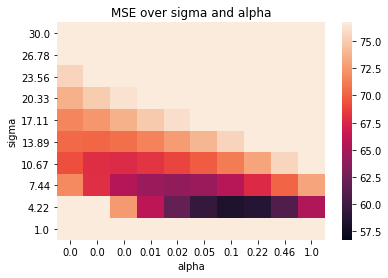

In [50]:
ax = sns.heatmap(errors_1, vmin=vmin, vmax=vmin+20,
                 xticklabels=errors_1.columns.values.round(2),
                 yticklabels=errors_1.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

### Alpha & Sigma Range 2

In [12]:
sigma_range = np.linspace(1, 8, 10)
alpha_range = np.logspace(-2, -0.5, 10)
    
errors_2 = calc_errors(sigma_range, alpha_range)

In [13]:
vmin = errors_2.values.min()
vmin

56.72597902047088

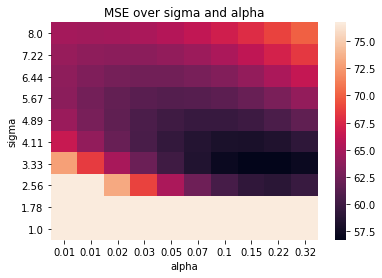

In [14]:
ax = sns.heatmap(errors_2, vmin=vmin, vmax=vmin+20,
                 xticklabels=errors_2.columns.values.round(2),
                 yticklabels=errors_2.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

### Alpha & Sigma Range 3

In [15]:
sigma_range = np.linspace(2, 5, 10)
alpha_range = np.logspace(-1, -0.5, 10)
    
errors_3 = calc_errors(sigma_range, alpha_range)

In [17]:
vmin = errors_3.values.min()
vmin

56.66991594567819

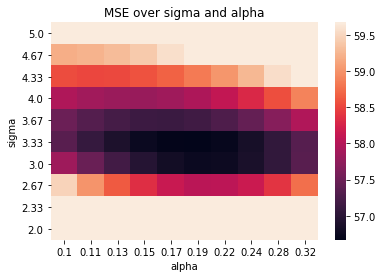

In [18]:
ax = sns.heatmap(errors_3, vmin=vmin, vmax=vmin+3,
                 xticklabels=errors_3.columns.values.round(2),
                 yticklabels=errors_3.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

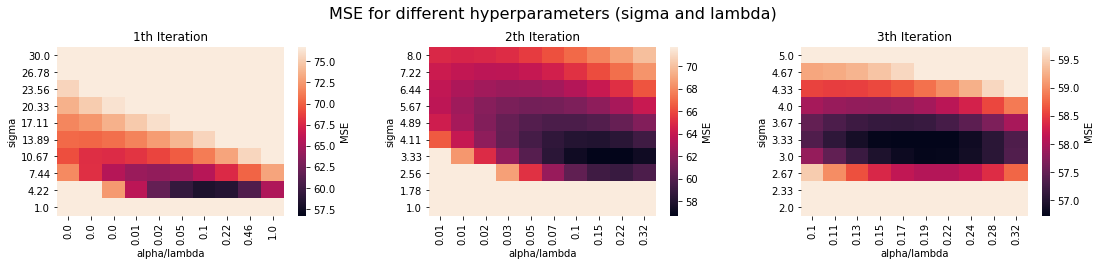

In [71]:
fig,axes = plt.subplots(nrows=1, ncols=3 ,figsize=(16,4)) 

data = [errors_1, errors_2, errors_3]
color_range = [20, 15, 3]

for i, ax in enumerate(axes):
    vmin = errors_2.values.min()
    ax = sns.heatmap(data[i], vmin=vmin, vmax=vmin+color_range[i],
                 xticklabels=data[i].columns.values.round(2),
                 yticklabels=data[i].index.values.round(2), ax=ax,
                cbar_kws={'label': 'MSE'})
    ax.set_ylabel('sigma')
    ax.set_xlabel('alpha/lambda')
    ax.set_title('{}th Iteration'.format(i+1))

fig.suptitle('MSE for different hyperparameters (sigma and lambda)', fontsize=16)

fig.tight_layout(pad=3)

plt.show()

---

In [38]:
errors_3_arr = errors_3.values
best_alpha_ind, best_alpha_ind = np.unravel_index(errors_3_arr.argmin(), errors_3_arr.shape)
best_alpha = errors_3.columns[best_alpha_ind]
best_sigma = errors_3.index[best_sigma_ind]

print("""Hyperparameters:
sigma: ~{:.4}
alpha: ~{:.4f}

Mean-Squared-Error: {}
""".format(best_sigma, best_alpha, errors_3_arr.min()))

Hyperparameters:
sigma: ~3.333
alpha: ~0.1896

Mean-Squared-Error: 56.66991594567819



In [42]:
# tweaked_model = rbf_ridge_model(best_sigma, best_alpha)
# hard-coded to prevent rerunning all the time
tweaked_model = rbf_ridge_model(3.333333333333333, 0.1895735652406376)
mean_squared_error(tweaked_model.predict(X_test), y_test)

57.45526372717967

## Duisburg

In [46]:
# peak demand
du = pd.DataFrame(duisburg.resample('H').count()["day"])
du.rename(columns={'day': 'demand'}, inplace=True)

du['dayofyear'] = du.index.map(lambda datetime : datetime.dayofyear)
du['week'] = du.index.map(lambda datetime : datetime.week)
du['weekday'] = du.index.map(lambda datetime : datetime.weekday)
du['is_weekday'] = du['weekday'].map(lambda day : day < 5)
du['hour'] = du.index.map(lambda datetime : datetime.hour)

du = du.merge(duisburg_weather, left_index=True, right_index=True)

In [47]:
X = du[['temperature', 'hour', 'precipitation', 'dayofyear']].values
y = du['demand'].values

In [48]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X,y)

train
        4392 entries
        ~0.50% of total data

        
validation
        1757 entries
        ~0.20% of total data

        
test
        2635 entries
        ~0.30% of total data

        


### Alpha & Sigma Range 1

In [50]:
sigma_range = np.linspace(1, 30, 10)
alpha_range = np.logspace(-3, 0, 10)
    
errors_1 = calc_errors(sigma_range, alpha_range)

In [ ]:
vmin = errors_1.values.min()
vmin

In [ ]:
ax = sns.heatmap(errors_1, vmin=vmin, vmax=vmin+20,
                 xticklabels=errors_1.columns.values.round(2),
                 yticklabels=errors_1.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

### Alpha & Sigma Range 2

In [ ]:
sigma_range = np.linspace(1, 30, 10)
alpha_range = np.logspace(-3, 0, 10)
    
errors_2 = calc_errors(sigma_range, alpha_range)

In [ ]:
vmin = errors_2.values.min()
vmin

In [ ]:
ax = sns.heatmap(errors_2, vmin=vmin, vmax=vmin+20,
                 xticklabels=errors_2.columns.values.round(2),
                 yticklabels=errors_2.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

### Alpha & Sigma Range 3

In [ ]:
sigma_range = np.linspace(1, 30, 10)
alpha_range = np.logspace(-3, 0, 10)
    
errors_3 = calc_errors(sigma_range, alpha_range)

In [ ]:
vmin = errors_3.values.min()
vmin

In [ ]:
ax = sns.heatmap(errors_3, vmin=vmin, vmax=vmin+20,
                 xticklabels=errors_3.columns.values.round(2),
                 yticklabels=errors_3.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()